# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
pd.set_option('display.max_rows', 40)
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [3]:
def categorize(df, col, nbins=10, quantiles=True):
    '''
    categorize continuous variable
    '''
    
    df1=df.copy()
    if quantiles:
        
        # create bin values based on quantiles
        quantiles = [df[col].quantile(0.1*i) for i in range(nbins)]
        bins=np.unique(quantiles)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        
        print(bins)
        print([i for i in range(len(bins)-1)])
        categorized = pd.cut(m2[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)], include_lowest=True)
    
        
    else:
        
        #create uniform bins values
        col_min, col_max = df[col].min(), df[col].max() 
        bins = [col_min+(col_max-col_min)/nbins*i for i in range(nbins)]
        bins = np.unique(bins)
        bins = np.append(-np.inf, bins)
        bins = np.append(bins, np.inf)
        categorized = pd.cut(m2[col], bins=bins, right=True, labels=[i for i in range(len(bins)-1)])
    col=col+'_categorized'
    df1[col] = categorized
    return df1

In [6]:
# check what are the types of channels
chans = set()
for i, row in portfolio.iterrows():
    chans.update(set(row.channels))
chans

In [38]:
transcript[transcript.event == 'offer received'].value.apply(lambda x: x.keys()).value_counts()

AttributeError: 'DataFrame' object has no attribute 'value'

In [15]:
# transcript[transcript.event=='offer viewed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='offer completed'].value.apply(lambda x: x.keys()).value_counts()
# transcript[transcript.event=='transaction'].value.apply(lambda x: x.keys()).value_counts()


In [18]:
transcript['key'] = transcript.value.apply(lambda x: list(x.keys())[0])
transcript['val'] = transcript.value.apply(lambda x: list(x.values())[0])
transcript.drop('value', axis=1, inplace=True)

0) Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

1) you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. 

2) you could build a model that predicts whether or not someone will respond to an offer.

3) Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [20]:
# merge transcript with profile

tp = pd.merge(transcript, profile, right_on = 'id', left_on ='person')

In [24]:
transcript[transcript.event=='offer received'].groupby(['person', 'val']).count()

event  \
person                           val                                       
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5      1   
                                 3f207df678b143eea3cee63160fa8bed      1   
                                 5a8bc65990b245e5a138643cd4eb9837      1   
                                 f19421c1d4aa40978ebb69ca19b0e20d      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   
...                                                                  ...   
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d      2   
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7      1   
                                 2906b810c7d4411798c6938adc9daaa5      3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9      1   
                                 fafdcd668e3743c1bb461111dcafc2a4      1   

                                                                   time  key  
person                           val                                          
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5     1    1  
                                 3f207df678b143eea3cee63160fa8bed     1    1  
                                 5a8bc65990b245e5a138643cd4eb9837     1    1  
                                 f19421c1d4aa40978ebb69ca19b0e20d     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  
...                                                                 ...  ...  
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d     2    2  
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7     1    1  
                                 2906b810c7d4411798c6938adc9daaa5     3    3  
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9     1    1  
                                 fafdcd668e3743c1bb461111dcafc2a4     1    1  

[63288 rows x 3 columns]

In [25]:
# conclusion: one person may receive the same offer few times

In [26]:
# split value column with dictionaries to key and value columns

In [27]:
# create column that indicates that val was completed

In [28]:
# create column offer for a given amount (offer which was before transaction) and column indicating if it is valid transaction
transcript['offer'] = 0 
for i, row in transcript.iterrows():
    if row.key == 'amount':
        if transcript.iloc[i-1].event == 'offer completed':
            transcript.iloc[i-1]['offer'] == transcript.iloc[i-1].val

# Create data which indicates whether the offer was successful or failure

In [29]:
# delete tarnsaction amount from the dataset as we will not analyse the the amount spent
df0 = transcript[transcript.event != 'transaction']

# create dataframe grouped by person and offer send to this person. Concatenate all the events related
# to an offer and person into one row
df1 = pd.DataFrame(df0.groupby(['person', 'val'])['event'].unique())

In [30]:
df1

event
person                           val                                                                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                [offer received, offer completed]
                                 3f207df678b143eea3cee63160fa8bed                   [offer received, offer viewed]
                                 5a8bc65990b245e5a138643cd4eb9837                   [offer received, offer viewed]
                                 f19421c1d4aa40978ebb69ca19b0e20d  [offer received, offer completed, offer viewed]
                                 fafdcd668e3743c1bb461111dcafc2a4  [offer received, offer completed, offer viewed]
...                                                                                                            ...
fffad4f4828548d1b5583907f2e9906b f19421c1d4aa40978ebb69ca19b0e20d  [offer received, offer viewed, offer completed]
ffff82501cea40309d5fdd7edcca4a07 0b1e1539f2cc45b7b9fa7c272da2e1d7  [offer received, offer viewed, offer completed]
                                 2906b810c7d4411798c6938adc9daaa5  [offer received, offer viewed, offer completed]
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9  [offer received, offer completed, offer viewed]
                                 fafdcd668e3743c1bb461111dcafc2a4  [offer received, offer viewed, offer completed]

[63288 rows x 1 columns]

In [31]:
# Need to merge with portfolio table

In [32]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [34]:
df1.head(2)

event
person                           val                                                                
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  [offer received, offer completed]
                                 3f207df678b143eea3cee63160fa8bed     [offer received, offer viewed]

In [35]:
# try different approach for checking successful columns

tp = pd.merge(transcript, portfolio, left_on='val', right_on = 'id')

In [39]:
# # offer1 column will tell with which eveent a given transaction is associated
# tp['offer1'] = tp.val
# # transaction is associated with the previous offer
# tp.offer1[tp.event=='transaction'] == 

In [ ]:
# for i in range(len(tp.event)):
#     if tp.event[i] =='transaction' and tp.event[i+1] =='transaction':
#         print(i)

In [98]:
tp.head()

,person,event,time,key,val,offer,reward,channels,difficulty,duration,offer_type,id,val1
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [36]:
# create column indicating whether an offer was successful or not

df1['success'] = 0
# we should treat informational offers separately
for i, row in df1.iterrows():
    if 
    # was the offer viewed and completed?
    if 'offer viewed' in row.event and 'offer completed' in row.event: 
        # was it viewed before completion? check the if position of 'offer viewed' is lower than position of 'offer completed'
        # in the list
        if np.where(row.event == 'offer viewed')[0][0] < np.where(row.event == 'offer completed')[0][0]:
            # the the offer was successful
            df1.loc[i, 'success'] = 1

In [37]:
# create column indicating whether an offer was failure or not

df1.reset_index(inplace=True)
df1['failure'] = 0
for i, row in df1.iterrows():
    # was the offer viewed and not completed ? then the offer was a failure
    if 'offer viewed' in row.event and 'offer completed'not in row.event: 
        # then the offer failed
        df1.loc[i, 'failure'] = 1

In [51]:
# how many offers do we have in the dataset which were neither viewed nor received
print(np.logical_and(df1.success==0, df1.failure==0).sum())
print(np.logical_and(df1.success==0, df1.failure==1).sum())
print(np.logical_and(df1.success==1, df1.failure==0).sum())
print(np.logical_and(df1.success==1, df1.failure==1).sum())

17861
24675
20752
0


In [39]:
# conclusion:
# there are offers which were neither failure nor success.
# They do not give any usefull information as we do not know if someone would
# complete the offer if he saw it before
# thus we will delete it

In [40]:
# those may be offers which were received but not viewed, thus we will not use those offers

In [41]:
df2 = df1[np.logical_or(df1.success==1, df1.failure==1)]

In [55]:
# lets drop failure column as now failure information is contained in the success column
df2.drop(['failure'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
# Now let us merge all three tables

In [58]:
m1 = pd.merge(df2, profile, left_on = 'person', right_on = 'id')

# merge the above result with portfolio table
m2 = pd.merge(m1, portfolio, left_on='val', right_on = 'id')

In [59]:
m2.head(2)

,index,person,val,event,success,gender,age,id_x,became_member_on,income,reward,channels,difficulty,duration,offer_type,id_y
0,1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
1,8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [60]:
# delete not usefull columns
m2.drop(['index', 'person', 'val', 'event', 'id_x', 'id_y'], axis=1,inplace=True)

In [61]:
m2.head(2)

,success,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,0,M,33,20170421,72000.0,0,"[web, email, mobile]",0,4,informational
1,0,O,40,20180109,57000.0,0,"[web, email, mobile]",0,4,informational


In [64]:
m2.isna().sum()

success                0
gender              6597
age                    0
became_member_on       0
income              6597
reward                 0
channels               0
difficulty             0
duration               0
offer_type             0
dtype: int64

In [67]:
# age equal to 118 is in fact NA. We can see that there is the same number of age eqaul to 118 
# as the number of missing observations in gender column

In [75]:
sum(m2.age==118)


0

In [74]:
m2.age[m2.age==118]=pd.NA

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
m2.isna().sum()

success                0
gender              6597
age                 6597
became_member_on       0
income              6597
reward                 0
channels               0
difficulty             0
duration               0
offer_type             0
dtype: int64

### Clean data part 2
create dummy variables of channel, offer_type, gender
categorize age, income, duration

In [77]:
# create dummy variables of channel
m2

,success,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,0,M,33.0,20170421,72000.0,0,"[web, email, mobile]",0,4,informational
1,0,O,40.0,20180109,57000.0,0,"[web, email, mobile]",0,4,informational
2,0,F,26.0,20170621,73000.0,0,"[web, email, mobile]",0,4,informational
3,0,M,54.0,20160821,91000.0,0,"[web, email, mobile]",0,4,informational
4,0,F,28.0,20170908,68000.0,0,"[web, email, mobile]",0,4,informational
...,...,...,...,...,...,...,...,...,...,...
45422,1,M,69.0,20180309,70000.0,2,"[web, email, mobile]",10,7,discount
45423,0,M,65.0,20180215,52000.0,2,"[web, email, mobile]",10,7,discount
45424,1,F,67.0,20170219,77000.0,2,"[web, email, mobile]",10,7,discount
45425,0,None,NaN,20171027,NaN,2,"[web, email, mobile]",10,7,discount


In [37]:
# m2 = pd.get_dummies(m2, columns=['gender', 'offer_type'], drop_first=False)
m2 = pd.get_dummies(m2, columns=['offer_type'], drop_first=False)

In [38]:
# m2[m2.success==1].event.value_counts()

In [39]:
# split event column
m2[['offer received', 'offer viewed', 'offer completed']] = 0

m2['offer received'] = m2['event'].apply(lambda x: 1 if 'offer received' in x else 0)
m2['offer viewed'] = m2['event'].apply(lambda x: 1 if 'offer viewed' in x else 0)
m2['offer completed'] = m2['event'].apply(lambda x: 1 if 'offer completed' in x else 0)

In [40]:
m2['web'] = m2['channels'].apply(lambda x: 1 if 'web' in x else 0)
m2['email'] = m2['channels'].apply(lambda x: 1 if 'email' in x else 0)
m2['mobile'] = m2['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
m2['social'] = m2['channels'].apply(lambda x: 1 if 'social' in x else 0)

In [41]:
m2.drop(labels=['person', 'val', 'event', 'id_x', 'id_y', 'channels'], axis=1)

,success,failure,gender,age,became_member_on,income,reward,difficulty,duration,offer_type_bogo,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social
0,0,1,M,33,20170421,72000.0,0,0,4,0,0,1,1,1,0,1,1,1,0
1,0,1,O,40,20180109,57000.0,0,0,4,0,0,1,1,1,0,1,1,1,0
2,0,1,F,26,20170621,73000.0,0,0,4,0,0,1,1,1,0,1,1,1,0
3,0,1,M,54,20160821,91000.0,0,0,4,0,0,1,1,1,0,1,1,1,0
4,0,1,F,28,20170908,68000.0,0,0,4,0,0,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45422,1,0,M,69,20180309,70000.0,2,10,7,0,1,0,1,1,1,1,1,1,0
45423,0,1,M,65,20180215,52000.0,2,10,7,0,1,0,1,1,0,1,1,1,0
45424,1,0,F,67,20170219,77000.0,2,10,7,0,1,0,1,1,1,1,1,1,0
45425,0,1,None,118,20171027,NaN,2,10,7,0,1,0,1,1,0,1,1,1,0


## which group responds the most to which offer type

In [42]:
m2.head(2)

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_bogo,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,0,1,1,1,0,1,1,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,0,1,1,1,0,1,1,1,0


In [43]:
# let's analyse which demographic groups (gender, age, income) responded the most to offers given to them

In [44]:
m2.columns

Index(['person', 'val', 'event', 'success', 'failure', 'gender', 'age', 'id_x',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'id_y', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'offer received', 'offer viewed',
       'offer completed', 'web', 'email', 'mobile', 'social'],
      dtype='object')

## 1) response to offers overall by gender

In [45]:
# sex
# categorize 
# new_m2 = categorize(m2, 'gender_M', 4)

# create 
df_sex_sum = pd.DataFrame(m2.groupby(['gender'])['success'].sum()).reset_index()
df_sex_count = pd.DataFrame(m2.groupby(['gender'])['success'].count()).reset_index()

mer = pd.merge(df_sex_sum, df_sex_count, on = ['gender'])
mer['offer_success_rate'] = mer.success_x/mer.success_y

In [46]:
mer

,gender,success_x,success_y,offer_success_rate
0,F,9181,15907,0.577167
1,M,10308,22311,0.462014
2,O,347,612,0.566993


In [47]:
# conclusion: Men were less likely to respond to the offer received

## 1) response to offers by age

In [48]:
new_m2 = categorize(m2, 'age', 4)

[-inf  18.  32.  42.  49.  inf]
[0, 1, 2, 3, 4]


In [49]:
# age
# categorize 
new_m2 = categorize(m2, 'age', 5)

# create 
df_age_sum = pd.DataFrame(new_m2.groupby(['age_categorized'])['success'].sum()).reset_index()
df_age_count = pd.DataFrame(new_m2.groupby(['age_categorized'])['success'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['age_categorized'])
mer['offer_success_rate'] = mer.success_x/mer.success_y

[-inf  18.  32.  42.  49.  54.  inf]
[0, 1, 2, 3, 4, 5]


In [50]:
mer

,age_categorized,success_x,success_y,offer_success_rate
0,0,68,167,0.407186
1,1,1917,4659,0.411462
2,2,2315,4720,0.490466
3,3,2350,4637,0.506793
4,4,2406,4520,0.532301
5,5,11696,26724,0.437659


In [51]:
# bar plot
import matplotlib.pyplot as plt
%matplotlib inline

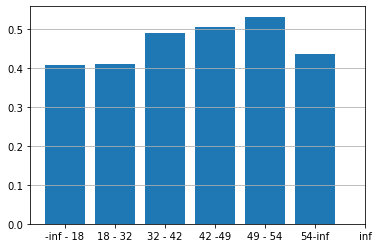

In [52]:
labels = ['-inf - 18','18 - 32', '32 - 42', '42 -49',  '49 - 54',  '54-inf', 'inf']
plt.bar(mer.age_categorized, mer.offer_success_rate)
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=labels)
plt.grid(axis='y')

In [67]:
# age
# categorize 
# new_m2 = categorize(m2, 'age', 5, quantiles=False)

# create 
df_age_sum = pd.DataFrame(m2.groupby(['gender'])['success'].sum()).reset_index()
df_age_count = pd.DataFrame(new_m2.groupby(['gender'])['success'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['gender'])
mer['offer_success_rate'] = mer.success_x/mer.success_y
mer

,gender,success_x,success_y,offer_success_rate
0,F,9181,15907,0.577167
1,M,10308,22311,0.462014
2,O,347,612,0.566993


Text(0.5, 0, 'gender')

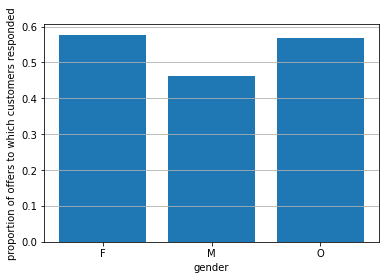

In [71]:
plt.bar(mer.gender, mer.offer_success_rate)
plt.grid(axis='y')
plt.ylabel('proportion of offers to which customers responded')
plt.xlabel('gender')

In [ ]:
# gender
# categorize 
categorize(m2, 'age', 5, quantiles=False)

# create 
df_age_sum = pd.DataFrame(new_m2.groupby(['age_categorized'])['success'].sum()).reset_index()
df_age_count = pd.DataFrame(new_m2.groupby(['age_categorized'])['success'].count()).reset_index()

mer = pd.merge(df_age_sum, df_age_count, on = ['age_categorized'])
mer['offer_success_rate'] = mer.success_x/mer.success_y

In [54]:
mer

,age_categorized,success_x,success_y,offer_success_rate
0,0,68,167,0.407186
1,1,3127,7149,0.437404
2,2,7975,15249,0.522985
3,3,6930,13116,0.528362
4,4,1695,3089,0.548721
5,5,957,6657,0.143758


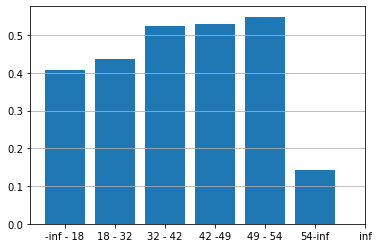

In [55]:
labels = ['-inf - 18','18 - 32', '32 - 42', '42 -49',  '49 - 54',  '54-inf', 'inf']
plt.bar(mer.age_categorized, mer.offer_success_rate)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=labels)
plt.grid(axis='y')

In [56]:
# conclusion: the older are the customers the more they responded to the offer

In [57]:
# income
# categorize 
new_m2 = categorize(m2, 'income', 5, quantiles=True)

# create 
df_income_sum = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].sum()).reset_index()
df_income_count = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].count()).reset_index()

income = pd.merge(df_income_sum, df_income_count, on = ['income_categorized'])
income['offer_success_rate'] = income.success_x/income.success_y

[  -inf 30000. 37000. 46000. 53000. 58000.    inf]
[0, 1, 2, 3, 4, 5]


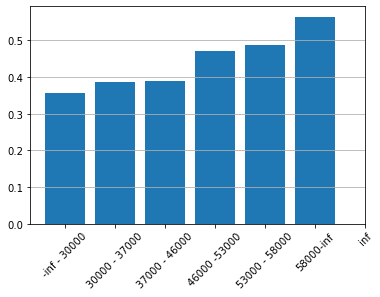

In [58]:
labels = ['-inf - 30000','30000 - 37000', '37000 - 46000', '46000 -53000',  '53000 - 58000',  '58000-inf', 'inf']
plt.bar(income.income_categorized, income.offer_success_rate)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=labels, rotation=45)
plt.grid(axis='y')

In [59]:
new_m2

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social,income_categorized
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,1,1,1,0,1,1,1,0,5
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,1,1,1,0,1,1,1,0,4
2,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,26,003d66b6608740288d6cc97a6903f4f0,20170621,73000.0,...,0,1,1,1,0,1,1,1,0,5
3,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,54,0056df74b63b4298809f0b375a304cf4,20160821,91000.0,...,0,1,1,1,0,1,1,1,0,5
4,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,28,0082fd87c18f45f2be70dbcbb0fb8aad,20170908,68000.0,...,0,1,1,1,0,1,1,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45422,ff40374e1ece425ea5ced2a3531bbe1c,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,M,69,ff40374e1ece425ea5ced2a3531bbe1c,20180309,70000.0,...,1,0,1,1,1,1,1,1,0,5
45423,ffd810f301ad42d6bfe98c4ba6ee4125,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,M,65,ffd810f301ad42d6bfe98c4ba6ee4125,20180215,52000.0,...,1,0,1,1,0,1,1,1,0,3
45424,ffeaa02452ef451082a0361c3ca62ef5,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,F,67,ffeaa02452ef451082a0361c3ca62ef5,20170219,77000.0,...,1,0,1,1,1,1,1,1,0,5
45425,ffecb1f8543f4bf7bade023de366d6bf,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,None,118,ffecb1f8543f4bf7bade023de366d6bf,20171027,NaN,...,1,0,1,1,0,1,1,1,0,NaN


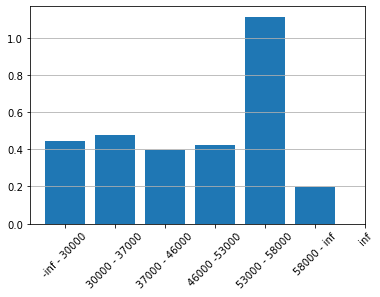

In [60]:
# income
# categorize 
new_m2 = categorize(m2, 'income', 5, quantiles=False)

# create 
df_income_sum = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].sum()).reset_index()
df_income_count = pd.DataFrame(new_m2.groupby(['income_categorized'])['success'].count()).reset_index()

income = pd.merge(df_income_sum, df_income_count, on = ['income_categorized'])
income['offer_success_rate'] = income.success_x/mer.success_y

# income = pd.concat([df_income_sum, df_income_count], axis=1)
labels = ['-inf - 30000','30000 - 37000', '37000 - 46000', '46000 -53000',  '53000 - 58000',  '58000 - inf', 'inf']
plt.bar(income.income_categorized, income.offer_success_rate)
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=labels, rotation=45)
plt.grid(axis='y')

In [73]:
# income, age
# categorize 

new_m2 = categorize(m2, 'age', 5, quantiles=False)
new_m2 = categorize(new_m2, 'income', 5, quantiles=False)

# create 
df_income_sum = pd.DataFrame(new_m2.groupby(['age_categorized', 'income_categorized'])['success'].sum()).reset_index()
df_income_count = pd.DataFrame(new_m2.groupby(['age_categorized', 'income_categorized'])['success'].count()).reset_index()

df_income_sum.rename(columns={'age_categorized': 'age_s', 'income_categorized': 'income_s', 'success': 'sum'}, inplace=True)
df_income_count.rename(columns={'age_categorized': 'age_c', 'income_categorized': 'income_c', 'success': 'count'}, inplace=True)

df_income_sum.rename(columns={'success': 'sum'})#, axis=columns, inplace=True)
con = pd.concat([df_income_sum, df_income_count], axis=1)

con['offer_success_rate'] = con['sum']/con['count']

In [74]:
new_m2[np.logical_and(new_m2.age_categorized==5, new_m2.income_categorized==0)]

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social,age_categorized,income_categorized


<AxesSubplot:xlabel='age_s', ylabel='offer_success_rate'>

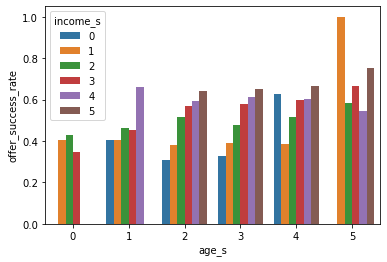

In [90]:
sns.barplot(x='age_s', y = 'offer_success_rate', data=con, hue = 'income_s')

In [76]:
con[['age_s', 'income_s', 'offer_success_rate']].sort_values('offer_success_rate')

,age_s,income_s,offer_success_rate
12,2,0,0.308642
18,3,0,0.326531
3,0,3,0.347826
13,2,1,0.381974
25,4,1,0.387629
19,3,1,0.390840
7,1,1,0.402514
1,0,1,0.405405
6,1,0,0.405797
2,0,2,0.428571


In [77]:
# TODO:

# use test for proportions

# Some interesting statistics

percentage of bogo offers: 0.4297003984414555
percentage of informational offers: 0.20492218284280272
percentage of discount offers: 0.36537741871574175


Text(0.5, 1.0, 'proportion of all offers')

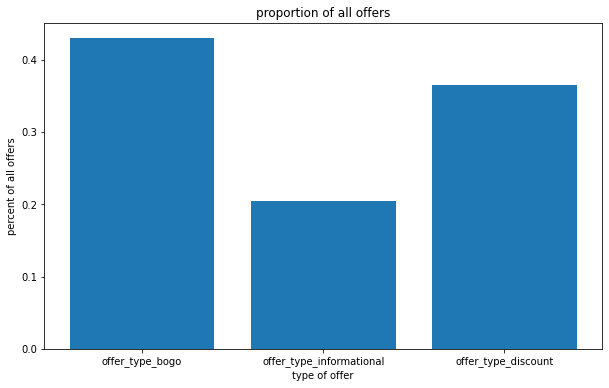

In [95]:
# percent of specific types of offers
m2['offer completed'].sum()/m2.shape[0]
print(f'percentage of bogo offers: {m2.offer_type_bogo.sum()/m2.shape[0]}')
print(f'percentage of informational offers: {m2.offer_type_informational.sum()/m2.shape[0]}')
print(f'percentage of discount offers: {m2.offer_type_discount.sum()/m2.shape[0]}')
d = m2[['offer_type_bogo', 'offer_type_informational', 'offer_type_discount']].sum(axis=0)/m2.shape[0]
plt.figure(figsize=(10,6))
plt.bar(d.index, d.values)
plt.xlabel('type of offer')
plt.ylabel('percent of all offers')
plt.title('proportion of all offers')

percentage of web offers: 0.2205711661841048
percentage of email offers: 0.2897093149322075
percentage of mobile offers: 0.2760934171758013
percentage of social offers: 0.21362610170788637


Text(0.5, 1.0, 'proportion of all offers')

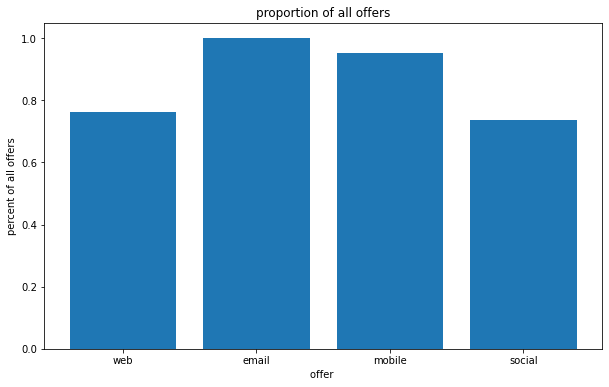

In [108]:
# percent of specific types of offers
print(f"percentage of web offers: {m2.web.sum()/m2[['web', 'email', 'mobile', 'social']].sum().sum()}")
print(f"percentage of email offers: {m2.email.sum()/m2[['web', 'email', 'mobile', 'social']].sum().sum()}")
print(f"percentage of mobile offers: {m2.mobile.sum()/m2[['web', 'email', 'mobile', 'social']].sum().sum()}")
print(f"percentage of social offers: {m2.social.sum()/m2[['web', 'email', 'mobile', 'social']].sum().sum()}")

d = m2[['web','email', 'mobile', 'social']].sum(axis=0)/m2.shape[0]
plt.figure(figsize=(10,6))
plt.bar(d.index, d.values)
plt.xlabel('offer ')
plt.ylabel('percent of all offers')
plt.title('proportion of all offers')

percentage of web offers: 0.533105880992309
percentage of email offers: 0.4568208334250556
percentage of mobile offers: 0.4514690935969694
percentage of social offers: 0.4696539988655701


Text(0.5, 1.0, 'proportion of all offers')

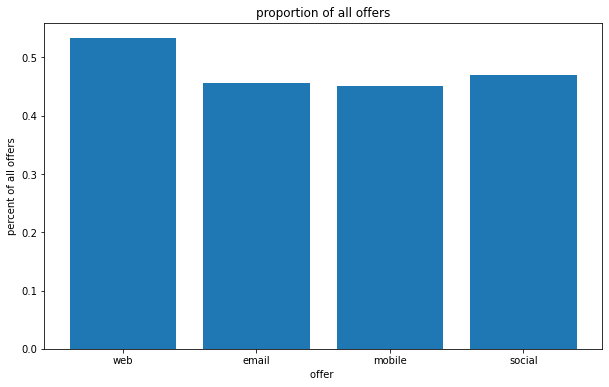

In [99]:
# what is percentage of completed offers in all types of offers
print(f'percentage of web offers: {m2[m2.success==1].web.sum()/m2.web.sum()}')
print(f'percentage of email offers: {m2[m2.success==1].email.sum()/m2.email.sum()}')
print(f'percentage of mobile offers: {m2[m2.success==1].mobile.sum()/m2.mobile.sum()}')
print(f'percentage of social offers: {m2[m2.success==1].social.sum()/m2.social.sum()}')

d = m2[m2.success==1][['web','email', 'mobile', 'social']].sum(axis=0)/m2[['web','email', 'mobile', 'social']].sum(axis=0)
plt.figure(figsize=(10,6))
plt.bar(d.index, d.values)
plt.xlabel('offer ')
plt.ylabel('percent of all offers')
plt.title('proportion of all offers')

In [96]:
m2

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_bogo,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,0,1,1,1,0,1,1,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,0,1,1,1,0,1,1,1,0
2,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,26,003d66b6608740288d6cc97a6903f4f0,20170621,73000.0,...,0,0,1,1,1,0,1,1,1,0
3,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,54,0056df74b63b4298809f0b375a304cf4,20160821,91000.0,...,0,0,1,1,1,0,1,1,1,0
4,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,28,0082fd87c18f45f2be70dbcbb0fb8aad,20170908,68000.0,...,0,0,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45422,ff40374e1ece425ea5ced2a3531bbe1c,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,M,69,ff40374e1ece425ea5ced2a3531bbe1c,20180309,70000.0,...,0,1,0,1,1,1,1,1,1,0
45423,ffd810f301ad42d6bfe98c4ba6ee4125,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,M,65,ffd810f301ad42d6bfe98c4ba6ee4125,20180215,52000.0,...,0,1,0,1,1,0,1,1,1,0
45424,ffeaa02452ef451082a0361c3ca62ef5,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,F,67,ffeaa02452ef451082a0361c3ca62ef5,20170219,77000.0,...,0,1,0,1,1,1,1,1,1,0
45425,ffecb1f8543f4bf7bade023de366d6bf,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,None,118,ffecb1f8543f4bf7bade023de366d6bf,20171027,NaN,...,0,1,0,1,1,0,1,1,1,0


# Create a report with offer type success rate and age, gender etc. 

In [113]:
# analyse which offer type was most sucessful in which group

In [114]:
m3 = pd.merge(m1, portfolio, left_on='val', right_on = 'id')

In [115]:
m3.groupby(['offer_type'])['success'].mean()

offer_type
bogo             0.502100
discount         0.659778
informational    0.000000
Name: success, dtype: float64

In [116]:
m3_age = categorize(m3, 'age', 5)
m3_age = categorize(m3_age, 'income', 4)

[-inf  18.  32.  42.  49.  54.  inf]
[0, 1, 2, 3, 4, 5]
[  -inf 30000. 37000. 46000. 53000.    inf]
[0, 1, 2, 3, 4]


In [117]:
m3_age = m3_age[['age_categorized', 'income_categorized', 'offer_type','gender', 'success', 'failure']]

In [118]:
# success rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=m3_age.success, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=1, aggfunc=sum)

In [119]:
# get division of that dataframe - success rate for each offer type and age
d = d1.divide(d2)

In [120]:
import seaborn as sns

In [121]:
# failure rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=m3_age.failure, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized], columns=m3_age.offer_type, values=1, aggfunc=sum)
# get division of that dataframe - success rate for each offer type and age
d1.divide(d2)

offer_type                              bogo  discount  informational
age_categorized income_categorized                                   
0               1                   0.333333  0.428571            1.0
                2                   0.764706  0.375000            1.0
                3                   0.481481  0.066667            1.0
                4                   0.714286  0.444444            1.0
1               0                   0.696970  0.333333            1.0
                1                   0.683673  0.336508            1.0
                2                   0.629032  0.356941            1.0
                3                   0.548287  0.253333            1.0
                4                   0.562708  0.347826            1.0
2               0                   0.500000  0.181818            1.0
                1                   0.610224  0.382488            1.0
                2                   0.609756  0.358025            1.0
                3                   0.484472  0.257261            1.0
                4                   0.380483  0.238390            1.0
3               0                   0.615385  0.363636            1.0
                1                   0.648936  0.362319            1.0
                2                   0.639269  0.368750            1.0
                3                   0.456067  0.307339            1.0
                4                   0.372110  0.248294            1.0
4               0                   0.625000  0.833333            1.0
                1                   0.616000  0.351064            1.0
                2                   0.576923  0.333333            1.0
                3                   0.425287  0.293233            1.0
                4                   0.313929  0.226613            1.0
5               0                   0.722222  0.428571            1.0
                1                   0.626308  0.367265            1.0
                2                   0.650218  0.342574            1.0
                3                   0.511111  0.331852            1.0
                4                   0.320671  0.222280            1.0

In [122]:
# add gender
# pd.set_option(display.maxrow,50)
# failure rate
d1=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized, m3_age.gender], columns=m3_age.offer_type, values=m3_age.failure, aggfunc=sum)
d2=pd.crosstab(index = [m3_age.age_categorized, m3_age.income_categorized, m3_age.gender], columns=m3_age.offer_type, values=1, aggfunc=sum)
# get division of that dataframe - success rate for each offer type and age
d1.divide(d2)



offer_type                                     bogo  discount  informational
age_categorized income_categorized gender                                   
0               1                  F       0.200000  1.000000            1.0
                                   M       0.500000  0.333333            NaN
                2                  F       1.000000  0.666667            1.0
                                   M       0.714286  0.307692            1.0
                3                  F       0.833333  0.000000            NaN
...                                             ...       ...            ...
5               3                  M       0.585502  0.341573            1.0
                                   O       0.230769  0.214286            1.0
                4                  F       0.268331  0.193537            1.0
                                   M       0.378441  0.251439            1.0
                                   O       0.255102  0.239583            1.0

[79 rows x 3 columns]

In [123]:
# TODO: select Which geneder is most influenced by offer within each (income, age) group

In [124]:
mer

,gender,success_x,success_y,offer_success_rate
0,F,9181,15907,0.577167
1,M,10308,22311,0.462014
2,O,347,612,0.566993


In [125]:
split = pd.DataFrame(m2['event'].to_list(), columns = ['offer received', 'offer viewed', 'offer completed'])

In [126]:
split['offer completed'].value_counts()

offer completed    20752
Name: offer completed, dtype: int64

In [127]:
m2.columns

Index(['person', 'val', 'event', 'success', 'failure', 'gender', 'age', 'id_x',
       'became_member_on', 'income', 'reward', 'channels', 'difficulty',
       'duration', 'id_y', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'offer received', 'offer viewed',
       'offer completed', 'web', 'email', 'mobile', 'social'],
      dtype='object')

In [128]:
qu = [m2.income.quantile(0.1*i) for i in range(10)]

In [129]:
pd.cut(m2.income, bins=qu, right=False, labels=[1,2,3,4,5,6,7,8,9])

0          7
1          4
2          7
3          9
4          6
        ... 
45422      7
45423      3
45424      8
45425    NaN
45426      5
Name: income, Length: 45427, dtype: category
Categories (9, int64): [1 < 2 < 3 < 4 ... 6 < 7 < 8 < 9]

In [130]:
m2.income.quantile(0),m2.income.quantile(1)

(30000.0, 120000.0)

In [131]:
X, y = m2[['age', 'became_member_on', 'income', 'reward', 'channels', 'difficulty', 'duration']], m2.success

### function to categorize a column

In [132]:
m3 = m2.copy()
m4 = m2.copy()

In [133]:
categorize(m3, 'age',nbins=3, quantiles=True)
categorize(m4, 'age', nbins=3, quantiles=False)
categorize(m3, 'income', nbins=3,quantiles=True)
categorize(m4, 'income', nbins=3, quantiles=False)

[-inf  18.  32.  42.  inf]
[0, 1, 2, 3]
[  -inf 30000. 37000. 46000.    inf]
[0, 1, 2, 3]


,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social,income_categorized
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,1,1,1,0,1,1,1,0,2
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,1,1,1,0,1,1,1,0,1
2,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,26,003d66b6608740288d6cc97a6903f4f0,20170621,73000.0,...,0,1,1,1,0,1,1,1,0,2
3,0056df74b63b4298809f0b375a304cf4,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,54,0056df74b63b4298809f0b375a304cf4,20160821,91000.0,...,0,1,1,1,0,1,1,1,0,3
4,0082fd87c18f45f2be70dbcbb0fb8aad,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,F,28,0082fd87c18f45f2be70dbcbb0fb8aad,20170908,68000.0,...,0,1,1,1,0,1,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45422,ff40374e1ece425ea5ced2a3531bbe1c,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,M,69,ff40374e1ece425ea5ced2a3531bbe1c,20180309,70000.0,...,1,0,1,1,1,1,1,1,0,2
45423,ffd810f301ad42d6bfe98c4ba6ee4125,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,M,65,ffd810f301ad42d6bfe98c4ba6ee4125,20180215,52000.0,...,1,0,1,1,0,1,1,1,0,1
45424,ffeaa02452ef451082a0361c3ca62ef5,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,F,67,ffeaa02452ef451082a0361c3ca62ef5,20170219,77000.0,...,1,0,1,1,1,1,1,1,0,2
45425,ffecb1f8543f4bf7bade023de366d6bf,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed]",0,1,None,118,ffecb1f8543f4bf7bade023de366d6bf,20171027,NaN,...,1,0,1,1,0,1,1,1,0,NaN


In [134]:
categorize(m1, 'income')

[  -inf 30000. 37000. 46000. 53000. 58000. 64000. 70000. 75000. 84000.
 95000.    inf]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


,person,val,event,success,failure,gender,age,id,became_member_on,income,income_categorized
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,7
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,4
2,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer viewed]",0,1,None,118,00116118485d4dfda04fdbaba9a87b5c,20180425,NaN,7
3,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer viewed, offer completed]",1,0,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,9
4,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,"[offer received, offer viewed, offer completed]",1,0,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,6
...,...,...,...,...,...,...,...,...,...,...,...
45422,fffad4f4828548d1b5583907f2e9906b,5a8bc65990b245e5a138643cd4eb9837,"[offer received, offer viewed]",0,1,M,34,fffad4f4828548d1b5583907f2e9906b,20170123,34000.0,6
45423,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,"[offer received, offer viewed, offer completed]",1,0,M,34,fffad4f4828548d1b5583907f2e9906b,20170123,34000.0,3
45424,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[offer received, offer viewed, offer completed]",1,0,F,45,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,8
45425,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,"[offer received, offer viewed, offer completed]",1,0,F,45,ffff82501cea40309d5fdd7edcca4a07,20161125,62000.0,NaN


In [135]:
m3.head(2)

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_bogo,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,0,1,1,1,0,1,1,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,0,1,1,1,0,1,1,1,0


In [136]:
# categorize columns: age, income

In [137]:
data = pd.get_dummies(m1, prefix = 'age_group',columns = ['age'], drop_first=True)

data = pd.get_dummies(data, prefix = 'income_group',columns = ['income'], drop_first=True)

In [138]:
# 1) Which age group is most influenced by adverts?

In [139]:
m3.groupby('age')['success'].mean()

age
18     0.407186
19     0.348083
20     0.393293
21     0.404011
22     0.398148
         ...   
98     0.400000
99     0.785714
100    0.718750
101    0.500000
118    0.138851
Name: success, Length: 85, dtype: float64

In [140]:
m4.groupby('age')['success'].mean()

age
18     0.407186
19     0.348083
20     0.393293
21     0.404011
22     0.398148
         ...   
98     0.400000
99     0.785714
100    0.718750
101    0.500000
118    0.138851
Name: success, Length: 85, dtype: float64

In [141]:
# Conclusion: the older people the more successful is the advertisement

In [142]:
m3.groupby('income')['success'].mean()

income
30000.0     0.357488
31000.0     0.397482
32000.0     0.375850
33000.0     0.389397
34000.0     0.373196
              ...   
116000.0    0.642105
117000.0    0.674699
118000.0    0.698529
119000.0    0.575221
120000.0    0.571429
Name: success, Length: 91, dtype: float64

In [143]:
m4.groupby('income')['success'].mean()

income
30000.0     0.357488
31000.0     0.397482
32000.0     0.375850
33000.0     0.389397
34000.0     0.373196
              ...   
116000.0    0.642105
117000.0    0.674699
118000.0    0.698529
119000.0    0.575221
120000.0    0.571429
Name: success, Length: 91, dtype: float64

In [144]:
# Conclusion the more rich is a given person the more likely to use copunes etc.

In [145]:
m3.head(2)

,person,val,event,success,failure,gender,age,id_x,became_member_on,income,...,offer_type_bogo,offer_type_discount,offer_type_informational,offer received,offer viewed,offer completed,web,email,mobile,social
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0,...,0,0,1,1,1,0,1,1,1,0
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,40,0011e0d4e6b944f998e987f904e8c1e5,20180109,57000.0,...,0,0,1,1,1,0,1,1,1,0


In [146]:
m3 = pd.get_dummies(m3, prefix = 'age_group',columns = ['age'], drop_first=True)
m3 = pd.get_dummies(m3, prefix = 'income_group',columns = ['income'], drop_first=True)

In [147]:
m3.channels

0        [web, email, mobile]
1        [web, email, mobile]
2        [web, email, mobile]
3        [web, email, mobile]
4        [web, email, mobile]
                 ...         
45422    [web, email, mobile]
45423    [web, email, mobile]
45424    [web, email, mobile]
45425    [web, email, mobile]
45426    [web, email, mobile]
Name: channels, Length: 45427, dtype: object

In [148]:
m3.head(2)

,person,val,event,success,failure,gender,id_x,became_member_on,reward,channels,...,income_group_111000.0,income_group_112000.0,income_group_113000.0,income_group_114000.0,income_group_115000.0,income_group_116000.0,income_group_117000.0,income_group_118000.0,income_group_119000.0,income_group_120000.0
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,M,0009655768c64bdeb2e877511632db8f,20170421,0,"[web, email, mobile]",...,0,0,0,0,0,0,0,0,0,0
1,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,"[offer received, offer viewed]",0,1,O,0011e0d4e6b944f998e987f904e8c1e5,20180109,0,"[web, email, mobile]",...,0,0,0,0,0,0,0,0,0,0


In [149]:
m3.drop(['person', 'val', 'event', 'failure', 'id_x', 'became_member_on', 'channels', 'duration', 'id_y'], axis=1, inplace=True)

In [150]:
X, y = m3.drop(['success'], axis=1), m3.success

In [151]:
# Which type of advertisement was most successful?

## train classifiers

In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [154]:
X_train.iloc[:,1:3]

,reward,difficulty
26587,10,10
27708,10,10
8651,0,0
7668,0,0
24237,5,5
...,...,...
11284,5,5
44732,2,10
38158,10,10
860,0,0


In [155]:
lr = LogisticRegression()
lr.fit(X_train.iloc[:, 2:], y_train,)

LogisticRegression()

In [156]:
Y_pred = lr.predict(X_test.iloc[:, 2:])

In [157]:
lr.coef_

array([[ 2.78333390e-02,  4.36611742e-01,  6.68228913e-01,
        -1.10506583e+00, -2.25178861e-04, -2.25178861e-04,
         1.35768462e+01,  3.18391075e-01, -2.25178861e-04,
         2.48805264e-01,  4.96575387e-02, -5.84074325e-02,
        -4.31890976e-02, -2.84996927e-02, -3.52273573e-02,
        -2.78605816e-02, -2.06018705e-02, -2.62188572e-02,
        -3.29002270e-02, -3.39438514e-02, -3.11829652e-02,
        -2.02867195e-02, -1.13974874e-02, -4.46395481e-02,
        -1.56714553e-02, -3.57142111e-02,  7.80559968e-03,
         1.11981098e-02, -8.49458551e-03,  9.99514679e-03,
         2.84120729e-02,  3.62494196e-02, -8.51435742e-03,
         2.19683824e-02, -4.26132607e-02,  1.59145256e-02,
         1.03962841e-03,  7.52749352e-03,  2.11834861e-02,
        -1.35059978e-03,  1.68687301e-02,  1.54403750e-02,
         2.36582819e-02,  2.18728254e-02,  5.39402397e-02,
         6.80208624e-02,  3.81775921e-02,  6.71716583e-02,
         1.91208622e-02,  2.89006217e-02,  3.42966676e-0

In [147]:
sum(Y_pred==y_test)/len(Y_pred)

1.0

In [107]:
confusion_matrix(y_test, Y_pred)

array([[4980,    0],
       [   0, 4106]], dtype=int64)